# Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_curve, auc
)

import shap
from xgboost import XGBClassifier

# Set display options
pd.set_option("display.max_columns", None)

# Ignore warnings
warnings.filterwarnings("ignore")

In [62]:
df = pd.read_csv('Cleaned.csv')

## Base Model

Using all the features to predict the label Outcome of acute kidney injury

Accuracy on test set: 0.82
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.84      0.84      0.84        44

    accuracy                           0.82        79
   macro avg       0.82      0.82      0.82        79
weighted avg       0.82      0.82      0.82        79



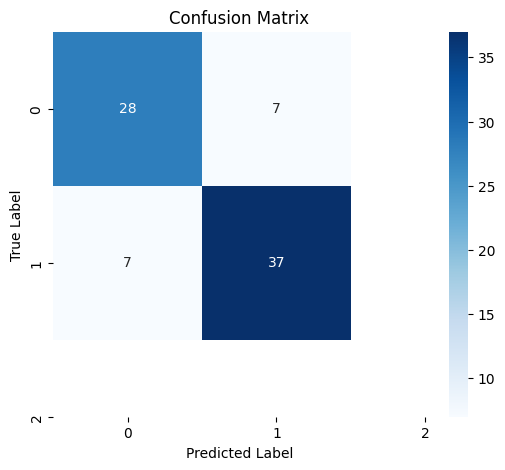

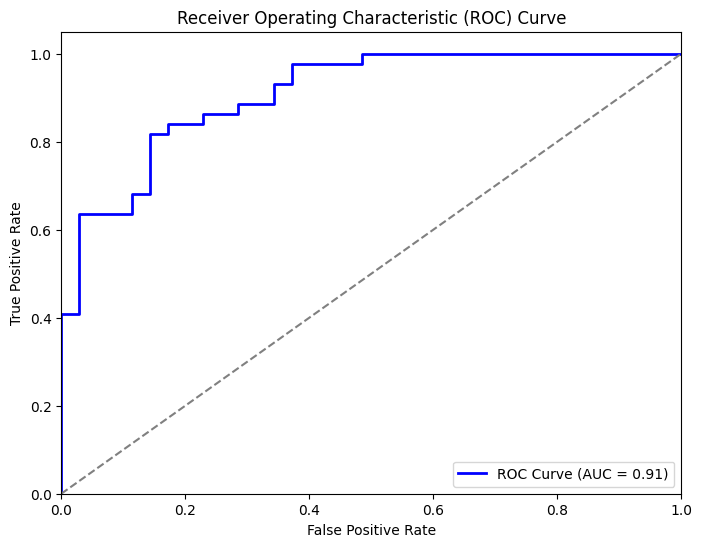

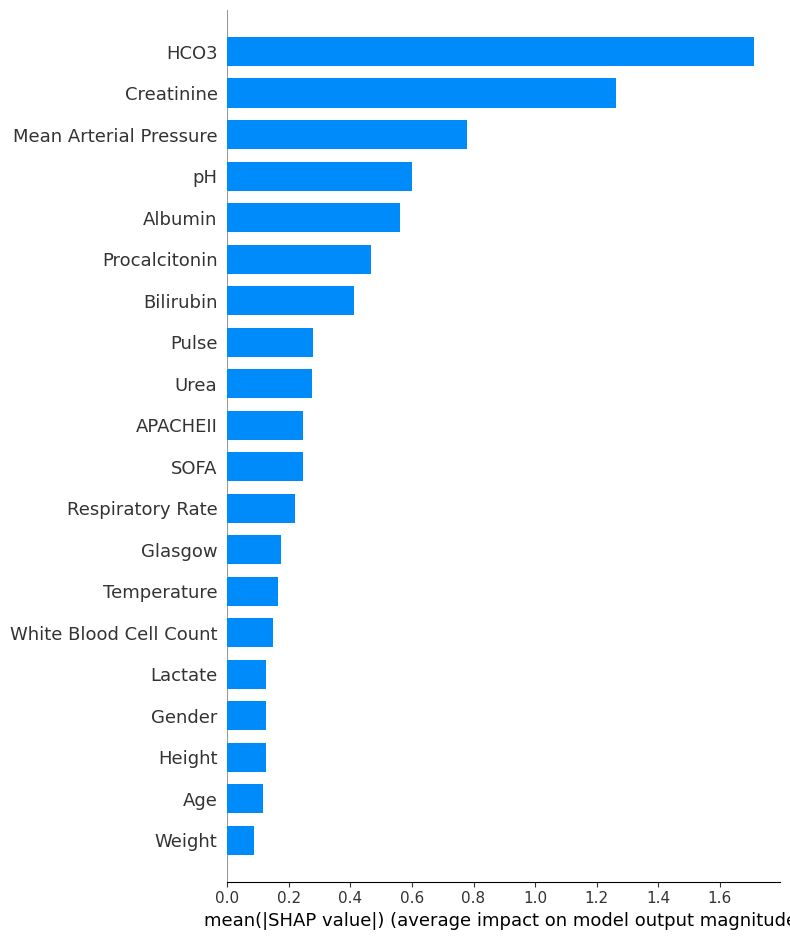

In [63]:
X = df[
    ['Gender', 'Age', 'Height', 'Weight', 'Route of Entry', 'Hypertension',
       'Diabetes', 'Mechanical Ventilation', 'Glasgow', 'Pulse', 'Temperature',
       'Mean Arterial Pressure', 'Respiratory Rate', 'SOFA', 'APACHEII', 'pH',
       'HCO3', 'Lactate', 'Urea', 'Creatinine', 'Procalcitonin', 'Bilirubin',
       'Albumin', 'White Blood Cell Count']
]

y = df['Outcome of acute kidney injury']

categorical_cols = X.select_dtypes(include=['object']).columns

X[categorical_cols] = X[categorical_cols].astype('category')

X_encoded = pd.get_dummies(X, columns=['Route of Entry'], drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42,stratify=y)

model = XGBClassifier(enable_categorical =True, random_state = 42)

model_XGB = model.fit(X_train, y_train)

pred = model_XGB.predict(X_test)

accuracy = accuracy_score(pred, y_test)

y_scores = model_XGB.predict_proba(X_test)[:, 1]  # Probability of the positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, pred)

print(f"Accuracy on test set: {accuracy:.2f}")
print(classification_report(y_test, pred))


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


---

# Model 2

Removing features which do not contribute much to the model.


## Intresting observation
- 'Route of Entry' did not show significance, it means that the model **relied more on lab values and severity scores**, which offer a **better physiological explanation** of AKI development.
- But when adjusting the threshold the model did not seem to get better but when I put Route of Entry back and adjusted the threshold the model got better. So keeping it in the model.

#### **Most Predictive Features Were Retained**  
The included variables strongly correlate with kidney function and dialysis needs, ensuring that key predictors were maintained.

#### **Redundant or Weak Features Were Removed**  
Features like **height, weight, and certain demographic factors** had little added value in predicting dialysis, so their removal did not negatively impact model performance.

#### **Clinical Indicators Were More Informative**  
Features related to **organ function, metabolic balance, and systemic illness** provided the most insight into dialysis need, making them the most valuable predictors.


Accuracy on test set: 0.82
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.84      0.84      0.84        44

    accuracy                           0.82        79
   macro avg       0.82      0.82      0.82        79
weighted avg       0.82      0.82      0.82        79



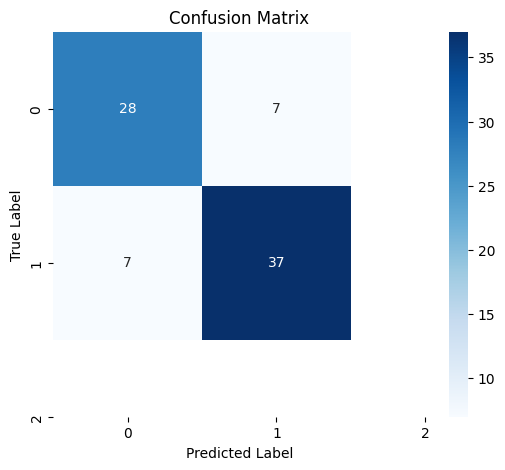

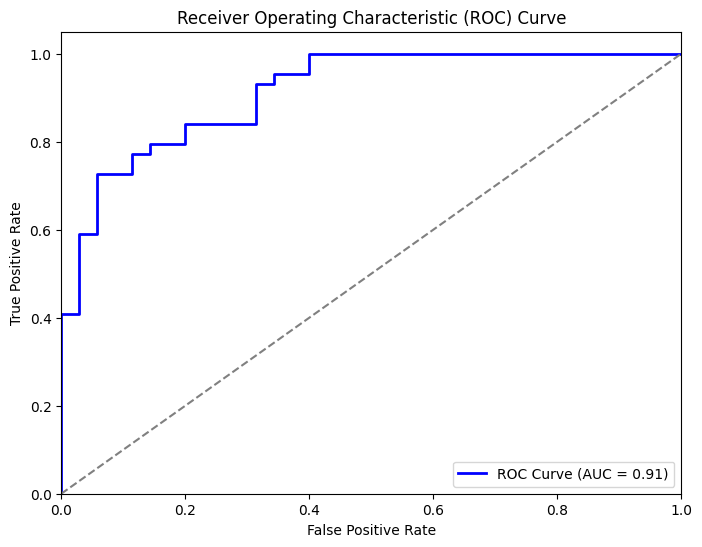

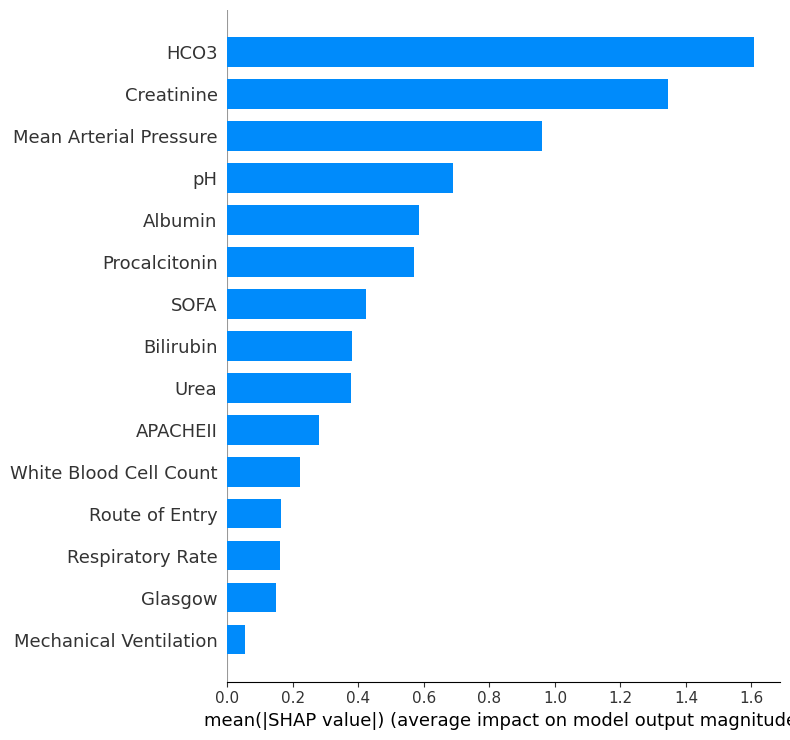

In [64]:
X = df[
    [
            'Route of Entry',
            'Mechanical Ventilation', 'Glasgow',
            'Mean Arterial Pressure', 'Respiratory Rate',
            'SOFA', 'APACHEII', 'pH', 'HCO3',  'Urea', 'Creatinine',
            'Procalcitonin', 'Bilirubin', 'Albumin', 'White Blood Cell Count', 
    ]
]

y = df['Outcome of acute kidney injury']

categorical_cols = X.select_dtypes(include=['object']).columns

X[categorical_cols] = X[categorical_cols].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

model = XGBClassifier(enable_categorical =True, random_state = 42)

model_XGB = model.fit(X_train, y_train)

pred = model_XGB.predict(X_test)

accuracy = accuracy_score(pred, y_test)

y_scores = model_XGB.predict_proba(X_test)[:, 1]  # Probability of the positive class
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, pred)

print(f"Accuracy on test set: {accuracy:.2f}")
print(classification_report(y_test, pred))


plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

The model was the same with removal of certain features.

---

# Model 3 adjusting threshold

## Recall vs. Precision for Dialysis

Metric	Impact	Importance in Dialysis

Recall:	
- Ensures all critical cases are detected, reducing false negatives	
- Most important (high recall needed)

Precision	
- Ensures that positive predictions are actually correct, reducing false positives	
- Less critical, but still relevant

## Prioritizing Recall

This model aims to reduce false negatives, ensuring that more positive cases are identified.

A lower threshold is used to classify more instances as positive.

Accuracy (Recall Priority): 0.82
Classification Report (Recall Priority):
               precision    recall  f1-score   support

           0       0.89      0.69      0.77        35
           1       0.79      0.93      0.85        44

    accuracy                           0.82        79
   macro avg       0.84      0.81      0.81        79
weighted avg       0.83      0.82      0.82        79



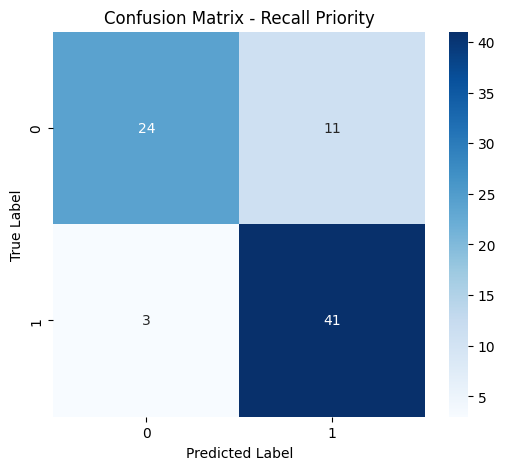

In [65]:
# Train the model
model_recall = XGBClassifier(enable_categorical=True, random_state=42)
model_recall.fit(X_train, y_train)

# Get predicted probabilities
y_scores_recall = model_recall.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Set a threshold to increase recall
threshold_recall = 0.2  
y_pred_recall = (y_scores_recall >= threshold_recall).astype(int)

# Evaluate performance
accuracy_recall = accuracy_score(y_test, y_pred_recall)
cm_recall = confusion_matrix(y_test, y_pred_recall)

# Print evaluation metrics
print(f"Accuracy (Recall Priority): {accuracy_recall:.2f}")
print("Classification Report (Recall Priority):\n", classification_report(y_test, y_pred_recall))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recall Priority")
plt.show()


## Prioritizing Precision

This model aims to reduce false positives, ensuring that only highly confident cases are classified as positive.

A higher threshold is used to be more selective.

Accuracy (Recall Priority): 0.81
Classification Report (Recall Priority):
               precision    recall  f1-score   support

           0       0.74      0.89      0.81        35
           1       0.89      0.75      0.81        44

    accuracy                           0.81        79
   macro avg       0.81      0.82      0.81        79
weighted avg       0.82      0.81      0.81        79



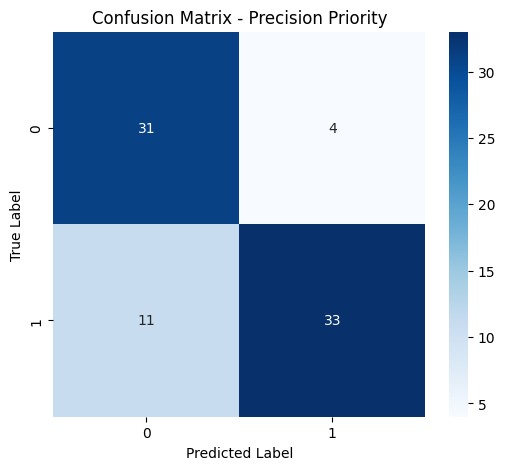

In [66]:
# Train the model
model_precision = XGBClassifier(enable_categorical=True, random_state=42)
model_precision.fit(X_train, y_train)

# Get predicted probabilities
y_scores_precision = model_precision.predict_proba(X_test)[:, 1]

# Set a higher threshold to increase precision
threshold_precision = 0.85  
y_pred_precision = (y_scores_precision >= threshold_precision).astype(int)

# Evaluate performance
accuracy_precision = accuracy_score(y_test, y_pred_precision)
cm_precision = confusion_matrix(y_test, y_pred_precision)

# Print evaluation metrics
print(f"Accuracy (Recall Priority): {accuracy_precision:.2f}")
print("Classification Report (Recall Priority):\n", classification_report(y_test, y_pred_precision))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_precision, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Precision Priority")
plt.show()


## Hyperparameter tuning

I have chosen a hybrid approach that optimizes both recall and precision, ensuring a balance between minimizing false negatives and false positives. This is crucial as AKI diagonis is both a costly treatment and a potentially life-saving intervention, making it essential to achieve the best possible predictive performance.

In [67]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 6, 9],  # Tree depth
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a leaf
    'subsample': [0.7, 0.8, 0.9],  # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used per tree
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required for split
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model_recall, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 6, 9], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [77]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 0.7}

Accuracy on test set: 0.84
Classification Report (Recall Priority):
               precision    recall  f1-score   support

           0       0.90      0.74      0.81        35
           1       0.82      0.93      0.87        44

    accuracy                           0.85        79
   macro avg       0.86      0.84      0.84        79
weighted avg       0.85      0.85      0.85        79



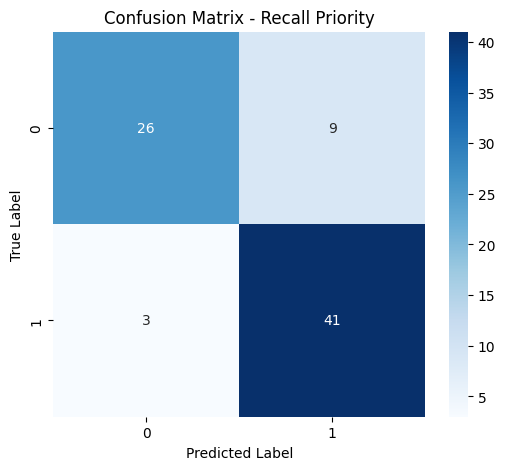

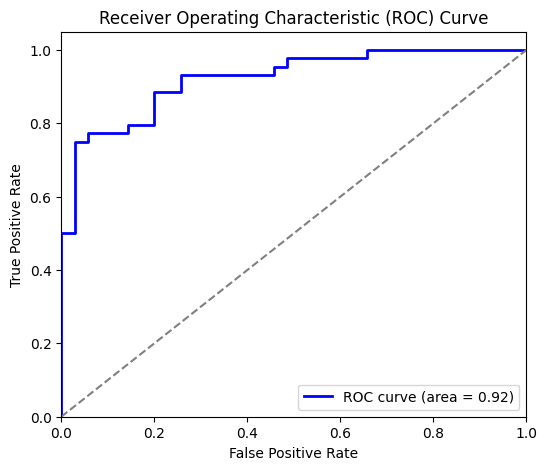

In [76]:
# Retrieve best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

# Compute predicted probabilities
y_scores = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# Set a lower threshold to increase recall
threshold_recall = 0.33  
y_pred_adjusted = (y_scores >= threshold_recall).astype(int)

# Compute confusion matrix and classification report for recall-prioritized model
cm_recall = confusion_matrix(y_test, y_pred_adjusted)
print("Classification Report (Recall Priority):\n", classification_report(y_test, y_pred_adjusted))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Recall Priority")
plt.show()

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
